# CSE527 Homework 6
**Due date: 23:59 on Dec. 5, 2019 (Thursday)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
In this homework we are going to work on estimating the 3D pose of a person given their 2D
pose. Turns out, just regressing the 3D pose coordinates using the 2D pose works pretty well [1]
(you can find the paper [here](https://arxiv.org/pdf/1705.03098.pdf)). In Part One, we are going to work on reproducing the results of the
paper, in Part Two, we are going to try to find a way to handle noisy measurement.

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.


## Starter Code
---
In the starter code, you are provided with a function that loads data into minibatches for training and testing in PyTorch.

## Benchmark
Train for a least 30 epochs to get a least 44mm avg error. The test result(mm error) should be in the following sequence **direct.	discuss.	eat.	greet.	phone	photo	pose	purch.	sit	sitd.	somke	wait	walkd.	walk	walkT	avg**

## Problem 1:
{60 points} Let us first start by trying to reproduce the testing accuracy obtained by in the [paper]((https://arxiv.org/pdf/1705.03098.pdf) above using
PyTorch. The 2D pose of a person is represented as a set of 2D coordinates for each of their $n = 32$ joints
i.e $P^{2D}_{i }$= {$(x^{1}_{i}, y^{1}_{i}), ...,(x^{32}_{i}, y^{32}_{i})$}, where $(x^{j}_{i}, y^{j}_{i})$ are the 2D coordinates of the $j$’th joint of the i’th sample. Similarly, the 3D pose of a person is 
$P^{3D}_{i}$ = {$(x^{1}_{i}, y^{1}_{i}, z^{1}_{i}), ...,(x^{32}_{i}, y^{32}_{i}, z^{32}_{i})$}, 
where $(x^{j}_{i}, y^{j}_{i}, z^{j}_{i})$ are the 3D coordinates of the $j$’th joint of the $i$’th sample. The only data given to you is the ground
truth 3D pose and the 2D pose calculated using the camera parameters. 
You are going to train a network $f_{θ} : R^{2n} → R^{3n}$ that takes as input the $P^{2D}_{i}$ and tries to regress the ground truth 3D pose $P^{3D}_{i}$. The loss function to train this network would be the $L2$ loss between the ground truth and the predicted pose
\begin{equation*}
L(\theta) = \sum^{M}_{i=1}(P^{3D}_{i} - f_{\theta}(P^{2D}_{i}))^{2} ;\;\;\;\;\;\;\;\; \text{for a minibatch of size M} \;\;\;\;\;\;\;\; (2)
\end{equation*}

Download the Human3.6M Dataset [here](https://www.dropbox.com/s/e35qv3n6zlkouki/h36m.zip).

**Bonus**: Every 1mm drop in test error from 44mm till 40mm gets you 2 extra points, and every 1mm drop below 40mm gets you 4 extra points.

In [1]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
pip install pykalman

     |████████████████████████████████| 235kB 6.3MB/s 
  Created wheel for pykalman: filename=pykalman-0.9.5-cp36-none-any.whl size=48464 sha256=e8f4e21597f4f3f54c03d55d5b696eb469869345fbce8db09f77b9c9a121a9f5
  Stored in directory: /root/.cache/pip/wheels/d9/e8/6a/553d9832679cb74a8434fa597c3abdb07313e40054a0adf9ac
Successfully built pykalman


In [0]:
from __future__ import print_function, absolute_import, division

import os
import sys
import time
from pprint import pprint
import numpy as np

import torch
import torch.nn as nn
import torch.optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from torch.autograd import Variable

# Locate to the src folder to import the following functions.
from procrustes import get_transformation
import procrustes
import data_process as data_process
import data_utils
import progress.progress.bar as pBar
import utils as utils
import misc as misc
import log as log
import cameras

from pykalman import KalmanFilter
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt

In [0]:
# Feel free to use more cells if necessary.

In [0]:
# Define actions
actions = data_utils.define_actions("All")

In [0]:
# Load camera parameters
SUBJECT_IDS = [1,5,6,7,8,9,11]
cameras_path = '../data/h36m/cameras.h5'
rcams = cameras.load_cameras(cameras_path, SUBJECT_IDS)

In [8]:
# Load data
data_dir = '../data/h36m/'
camera_frame = True
predict_14 = False
# Load 3d data and load (or create) 2d projections
train_set_3d, test_set_3d, data_mean_3d, data_std_3d, dim_to_ignore_3d, dim_to_use_3d, train_root_positions, test_root_positions = data_utils.read_3d_data(
    actions, data_dir, camera_frame, rcams, predict_14 )

Reading subject 1, action Directions
../data/h36m/S1/MyPoses/3D_positions/Directions*.h5
../data/h36m/S1/MyPoses/3D_positions/Directions 1.h5
../data/h36m/S1/MyPoses/3D_positions/Directions.h5
Reading subject 1, action Discussion
../data/h36m/S1/MyPoses/3D_positions/Discussion*.h5
../data/h36m/S1/MyPoses/3D_positions/Discussion 1.h5
../data/h36m/S1/MyPoses/3D_positions/Discussion.h5
Reading subject 1, action Eating
../data/h36m/S1/MyPoses/3D_positions/Eating*.h5
../data/h36m/S1/MyPoses/3D_positions/Eating 2.h5
../data/h36m/S1/MyPoses/3D_positions/Eating.h5
Reading subject 1, action Greeting
../data/h36m/S1/MyPoses/3D_positions/Greeting*.h5
../data/h36m/S1/MyPoses/3D_positions/Greeting 1.h5
../data/h36m/S1/MyPoses/3D_positions/Greeting.h5
Reading subject 1, action Phoning
../data/h36m/S1/MyPoses/3D_positions/Phoning*.h5
../data/h36m/S1/MyPoses/3D_positions/Phoning 1.h5
../data/h36m/S1/MyPoses/3D_positions/Phoning.h5
Reading subject 1, action Photo
../data/h36m/S1/MyPoses/3D_positions/Ph

/content/gdrive/My Drive/CV assignments/Shah_Karan_112715555_hw6/src/data_utils.py:462: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  complete_train = copy.deepcopy( np.vstack( train_set.values() ))


In [9]:
# Read stacked hourglass 2D predictions if use_sh, otherwise use groundtruth 2D projections
use_sh = False
if use_sh:
    train_set_2d, test_set_2d, data_mean_2d, data_std_2d, dim_to_ignore_2d, dim_to_use_2d = data_utils.read_2d_predictions(actions, data_dir)
else:
    train_set_2d, test_set_2d, data_mean_2d, data_std_2d, dim_to_ignore_2d, dim_to_use_2d = data_utils.create_2d_data( actions, data_dir, rcams )
print( "done reading and normalizing data." )

stat_3d = {}
stat_3d['mean'] = data_mean_3d
stat_3d['std'] = data_std_3d
stat_3d['dim_use'] = dim_to_use_3d

Reading subject 1, action Directions
../data/h36m/S1/MyPoses/3D_positions/Directions*.h5
../data/h36m/S1/MyPoses/3D_positions/Directions 1.h5
../data/h36m/S1/MyPoses/3D_positions/Directions.h5
Reading subject 1, action Discussion
../data/h36m/S1/MyPoses/3D_positions/Discussion*.h5
../data/h36m/S1/MyPoses/3D_positions/Discussion 1.h5
../data/h36m/S1/MyPoses/3D_positions/Discussion.h5
Reading subject 1, action Eating
../data/h36m/S1/MyPoses/3D_positions/Eating*.h5
../data/h36m/S1/MyPoses/3D_positions/Eating 2.h5
../data/h36m/S1/MyPoses/3D_positions/Eating.h5
Reading subject 1, action Greeting
../data/h36m/S1/MyPoses/3D_positions/Greeting*.h5
../data/h36m/S1/MyPoses/3D_positions/Greeting 1.h5
../data/h36m/S1/MyPoses/3D_positions/Greeting.h5
Reading subject 1, action Phoning
../data/h36m/S1/MyPoses/3D_positions/Phoning*.h5
../data/h36m/S1/MyPoses/3D_positions/Phoning 1.h5
../data/h36m/S1/MyPoses/3D_positions/Phoning.h5
Reading subject 1, action Photo
../data/h36m/S1/MyPoses/3D_positions/Ph

/content/gdrive/My Drive/CV assignments/Shah_Karan_112715555_hw6/src/data_utils.py:419: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  complete_train = copy.deepcopy( np.vstack( train_set.values() ))


done reading and normalizing data.


In [0]:
# ============================
#   Define Train/Test Methods
# ============================
def train(train_loader, model, criterion, optimizer,
          lr_init=None, lr_now=None, glob_step=None, lr_decay=None, gamma=None,
          max_norm=True):
  
    # Write you code here    
    losses = utils.AverageMeter()
    model.train()
    all_dist = []

    for i, (inps, tars) in enumerate(train_loader):

        if glob_step == 1:
            lr_now = utils.lr_decay(optimizer, glob_step, lr_init, lr_decay, gamma)
        glob_step += 1

        inputs = Variable(inps.cuda())
        targets = Variable(tars.cuda(async=True))

        outputs = model(inputs)
        outputs_coord = outputs
        
        optimizer.zero_grad()
        loss = criterion(outputs, targets)
        losses.update(loss.item(), inputs.size(0))
        loss.backward()

        if max_norm:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1) # clipping gradients if >1
        optimizer.step()

        tars = targets
        targets_unnorm = data_process.unNormalizeData(tars.data.cpu().numpy(), stat_3d['mean'], stat_3d['std'], stat_3d['dim_use'])
        outputs_unnorm = data_process.unNormalizeData(outputs.data.cpu().numpy(), stat_3d['mean'], stat_3d['std'], stat_3d['dim_use'])

        dim_use = np.hstack((np.arange(3), stat_3d['dim_use']))

        outputs_use = outputs_unnorm[:, dim_use]
        targets_use = targets_unnorm[:, dim_use]

        if procrustes:
            for ba in range(inps.size(0)):
                gt = targets_use[ba].reshape(-1, 3)
                out = outputs_use[ba].reshape(-1, 3)
                _, Z, T, b, c = get_transformation(gt, out, True)
                out = (b * out.dot(T)) + c
                outputs_use[ba, :] = out.reshape(1, 51)

        sqerr = (outputs_use - targets_use) ** 2

        distance = np.zeros((sqerr.shape[0], 17))
        dist_idx = 0
        for k in np.arange(0, 17 * 3, 3):
            distance[:, dist_idx] = np.sqrt(np.sum(sqerr[:, k:k + 3], axis=1))
            dist_idx += 1
        all_dist.append(distance)

        
    all_dist = np.vstack(all_dist)
    joint_err = np.mean(all_dist, axis=0)
    ttl_err = np.mean(all_dist)
  
    return glob_step, lr_now, losses.avg, ttl_err


def test(test_loader, model, criterion, stat_3d, procrustes=False):
    losses = utils.AverageMeter()

    model.eval()

    all_dist = []
    start = time.time()
    batch_time = 0
    bar = pBar.Bar('>>>', fill='>', max=len(test_loader))

    for i, (inps, tars) in enumerate(test_loader):
        inputs = Variable(inps.cuda())
        # inputs = Variable()

        targets = Variable(tars.cuda(async=True))
        # targets = Variable()

        outputs = model(inputs)

        # calculate loss
        outputs_coord = outputs
        loss = criterion(outputs_coord, targets)

        losses.update(loss.item(), inputs.size(0))

        tars = targets

        # calculate erruracy
        targets_unnorm = data_process.unNormalizeData(tars.data.cpu().numpy(), stat_3d['mean'], stat_3d['std'], stat_3d['dim_use'])
        outputs_unnorm = data_process.unNormalizeData(outputs.data.cpu().numpy(), stat_3d['mean'], stat_3d['std'], stat_3d['dim_use'])

        # remove dim ignored
        dim_use = np.hstack((np.arange(3), stat_3d['dim_use']))

        outputs_use = outputs_unnorm[:, dim_use]
        targets_use = targets_unnorm[:, dim_use]

        if procrustes:
            for ba in range(inps.size(0)):
                gt = targets_use[ba].reshape(-1, 3)
                out = outputs_use[ba].reshape(-1, 3)
                _, Z, T, b, c = get_transformation(gt, out, True)
                out = (b * out.dot(T)) + c
                outputs_use[ba, :] = out.reshape(1, 51)

        sqerr = (outputs_use - targets_use) ** 2

        distance = np.zeros((sqerr.shape[0], 17))
        dist_idx = 0
        for k in np.arange(0, 17 * 3, 3):
            distance[:, dist_idx] = np.sqrt(np.sum(sqerr[:, k:k + 3], axis=1))
            dist_idx += 1
        all_dist.append(distance)

        # update summary
        if (i + 1) % 100 == 0:
            batch_time = time.time() - start
            start = time.time()

        bar.suffix = '({batch}/{size}) | batch: {batchtime:.4}ms | Total: {ttl} | ETA: {eta:} | loss: {loss:.6f}' \
            .format(batch=i + 1,
                    size=len(test_loader),
                    batchtime=batch_time * 10.0,
                    ttl=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg)
        bar.next()

    all_dist = np.vstack(all_dist)
    joint_err = np.mean(all_dist, axis=0)
    ttl_err = np.mean(all_dist)
    bar.finish()
    print (">>> error: {} <<<".format(ttl_err))
    return losses.avg, ttl_err

In [0]:
# ==================
#   Dataset class
# ==================
from torch.utils.data import Dataset
TRAIN_SUBJECTS = [1, 5, 6, 7, 8]
TEST_SUBJECTS = [9, 11]

class Human36M(Dataset):
    def __init__(self, actions, data_path, use_hg=True, is_train=True):
        """
        :param actions: list of actions to use
        :param data_path: path to dataset
        :param use_hg: use stacked hourglass detections
        :param is_train: load train/test dataset
        """

        # Write you code here

        self.train_inp, self.train_out, self.test_inp, self.test_out = [], [], [], []
        
        # Write you code here
        self.is_train = is_train
        self.actions = actions

        if self.is_train:
            self.train_3d = train_set_3d
            self.train_2d = train_set_2d
            for key in self.train_2d.keys():
                if key[0] in TRAIN_SUBJECTS:
                  for i in range(len(self.train_2d[key])):
                      self.train_inp.append(self.train_2d[key][i])
                      self.train_out.append(self.train_3d[key][i])
                else:
                  print("ignoring", key)

        else:
            self.test_3d = test_set_3d
            self.test_2d = test_set_2d
            for key in self.test_2d.keys():
                if key[1] not in self.actions:
                    continue
                if key[0] in TEST_SUBJECTS:
                  for i in range(len(self.test_2d[key])):
                      self.test_inp.append(self.test_2d[key][i])
                      self.test_out.append(self.test_3d[key][i])
                else:
                  print("ignoring", key)

    def __getitem__(self, index):
        if self.is_train:
            inputs = torch.from_numpy(self.train_inp[index])
            outputs = torch.from_numpy(self.train_out[index])
        else:
            inputs = torch.from_numpy(self.test_inp[index])
            outputs = torch.from_numpy(self.test_out[index])
        return inputs.float(), outputs.float()

    def __len__(self):
      return len(self.train_inp) if self.is_train else len(self.test_inp)

In [0]:
# ==========================================
#       Define Network Architecture
# ==========================================
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)

# Write you code here
class network(nn.Module):
    def __init__(self):
        super(network, self).__init__()

        self.input_size =  32
        self.output_size = 48

        self.first = nn.Linear(self.input_size, 1024)
        self.batch_norm = nn.BatchNorm1d(1024)
        self.mid1 = nn.Linear(1024, 1024)
        self.batch_norm1 = nn.BatchNorm1d(1024)
        self.mid2 = nn.Linear(1024, 1024)
        self.batch_norm2 = nn.BatchNorm1d(1024)
        self.mid3 = nn.Linear(1024, 1024)
        self.batch_norm3 = nn.BatchNorm1d(1024)
        self.mid4 = nn.Linear(1024, 1024)
        self.batch_norm4 = nn.BatchNorm1d(1024)
        self.last = nn.Linear(1024, self.output_size)

        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x): # architecture as mentioned in paper
        #initial
        y = self.first(x)
        y1 = self.dropout(self.relu(self.batch_norm(y)))
        
        #block1
        y = self.mid1(y1)
        y = self.dropout(self.relu(self.batch_norm1(y)))

        y = self.mid2(y)
        y = self.dropout(self.relu(self.batch_norm2(y)))

        y1 = y + y1
        
        #block2
        y = self.mid3(y1)
        y = self.dropout(self.relu(self.batch_norm3(y)))

        y = self.mid4(y)
        y = self.dropout(self.relu(self.batch_norm4(y)))

        y1 = y + y1
        
        #last
        y = self.last(y1)
        return y

In [25]:
# ==========================================
#         load dadasets for training
# ==========================================
job = 8
use_hg = False
batch_size = 64
train_loader = DataLoader(dataset=Human36M(actions=actions, data_path=None, use_hg=use_hg, is_train=True), batch_size=batch_size, shuffle=True, num_workers=job, pin_memory=True)
test_loader = DataLoader(dataset=Human36M(actions=actions, data_path=None, use_hg=use_hg, is_train=False), batch_size=batch_size, shuffle=False, num_workers=job, pin_memory=True)

print(">>> data loaded !")

>>> data loaded !


In [0]:
# ==========================================
#         Optimize/Train Network
# ==========================================

# Write you code here
epochs = 33
lr = 1e-3
lr_now = lr
glob_step = 1
lr_decay = 1e+5 # decay_steps 
gamma = 1 # decay_rate
max_norm=True # grad clip
procrustes = True
model = network().cuda()
model.apply(weight_init)
criterion = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print("Training Started!")
minerr = 45
for epoch in range(epochs):
  glob_step, lr_now, loss_train, err_train = train(train_loader, model, criterion, optimizer, lr_init=lr, lr_now=lr_now, glob_step=glob_step, lr_decay=lr_decay, gamma=gamma, max_norm=max_norm)
  loss_test, err_test = test(test_loader, model, criterion, stat_3d, procrustes=procrustes)
  if err_test < minerr:
    torch.save({'state_dict': model.state_dict()}, 'model_' + str(err_test)[:5]+ '.pth')
    minerr = err_test
  print("epoch=>", epoch+1, "train loss=>", loss_train, 'train err=>', err_train, "test loss=>", loss_test, 'test err=>', err_test) 

Training Started!
>>> error: 43.621140677966395 <<<
epoch=> 1 train loss=> 0.14857783601524796 train err=> 63.5091663485707 test loss=> 0.06039729385394094 test err=> 43.621140677966395
>>> error: 42.180654098510296 <<<
epoch=> 2 train loss=> 0.08838798123088872 train err=> 54.096579669017345 test loss=> 0.053470068064951304 test err=> 42.180654098510296
>>> error: 40.18234031262952 <<<
epoch=> 3 train loss=> 0.07891043309433368 train err=> 51.724752043416245 test loss=> 0.04866748149032261 test err=> 40.18234031262952
>>> error: 39.770933041002706 <<<
epoch=> 4 train loss=> 0.07357698309408638 train err=> 50.23462907393977 test loss=> 0.047437847736694426 test err=> 39.770933041002706
>>> error: 38.851327343536795 <<<
epoch=> 5 train loss=> 0.0700178521905287 train err=> 49.20557405868452 test loss=> 0.04553114627111095 test err=> 38.851327343536795
>>> error: 37.973789048489344 <<<
epoch=> 6 train loss=> 0.06737875683351156 train err=> 48.39474640272409 test loss=> 0.0440194865959443

In [18]:
model = network().cuda()
model.load_state_dict(torch.load('model_35.57.pth')['state_dict'])
model.eval()

network(
  (first): Linear(in_features=32, out_features=1024, bias=True)
  (batch_norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mid1): Linear(in_features=1024, out_features=1024, bias=True)
  (batch_norm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mid2): Linear(in_features=1024, out_features=1024, bias=True)
  (batch_norm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mid3): Linear(in_features=1024, out_features=1024, bias=True)
  (batch_norm3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mid4): Linear(in_features=1024, out_features=1024, bias=True)
  (batch_norm4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (last): Linear(in_features=1024, out_features=48, bias=True)
  (relu): ReLU(inplace=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [32]:
# ==========================================
#            Evaluating Network
# ==========================================

err_set = []
for action in actions:
    print (">>> TEST on _{}_".format(action))
    test_loader = DataLoader(
                dataset=Human36M(actions=action, data_path=data_dir, use_hg=use_hg, is_train=False),
                batch_size=batch_size,
                shuffle=False,
                num_workers=job,
                pin_memory=True)
    _, err_test = test(test_loader, model, criterion, stat_3d, procrustes=procrustes)
    err_set.append(err_test)

print (">>>>>> TEST results:")
for action in actions:
    print ("{}".format(action), end='\t')
print ("\n")
for err in err_set:
    print ("{:.4f}".format(err), end='\t')
print (">>>\nERRORS: {}".format(np.array(err_set).mean()))

>>> TEST on _Directions_
>>> error: 29.431925032316958 <<<
>>> TEST on _Discussion_
>>> error: 33.343995623113535 <<<
>>> TEST on _Eating_
>>> error: 31.75132871025416 <<<
>>> TEST on _Greeting_
>>> error: 34.425913797112266 <<<
>>> TEST on _Phoning_
>>> error: 35.80718585140732 <<<
>>> TEST on _Photo_
>>> error: 41.04975678720734 <<<
>>> TEST on _Posing_
>>> error: 34.73772762003982 <<<
>>> TEST on _Purchases_
>>> error: 30.88072093357265 <<<
>>> TEST on _Sitting_
>>> error: 40.968463251932334 <<<
>>> TEST on _SittingDown_
>>> error: 43.78295176432944 <<<
>>> TEST on _Smoking_
>>> error: 37.036448305489245 <<<
>>> TEST on _Waiting_
>>> error: 35.563704986073766 <<<
>>> TEST on _WalkDog_
>>> error: 37.49565340731514 <<<
>>> TEST on _Walking_
>>> error: 30.033912927260978 <<<
>>> TEST on _WalkTogether_
>>> error: 31.69926405292038 <<<
>>>>>> TEST results:
Directions	Discussion	Eating	Greeting	Phoning	Photo	Posing	Purchases	Sitting	SittingDown	Smoking	Waiting	WalkDog	Walking	WalkTogether

Report the test result(mm error) in the following sequence **direct.	discuss.	eat.	greet.	phone	photo	pose	purch.	sit	sitd.	somke	wait	walkd.	walk	walkT	avg**

## Problem 2:
{40 points} In this task, we’re going to tackle the situation of having a faulty 3D sensor. Since the sensor is quite old it’s joint detections are quite noisy:
\begin{equation*}
 \hat{x} = x_{GT} + \epsilon_x \\
 \hat{y} = y_{GT} + \epsilon_y \\
 \hat{z} = z_{GT} + \epsilon_z
\end{equation*}

Where, ($x_{GT}, y_{GT}, z_{GT}$) are the ground truth joint locations, ($\hat{x}, \hat{y}, \hat{z}$) are the noisy measurements detected by our sensor and ($\epsilon_x, \epsilon_y, \epsilon_z$) are the noise values. Being grad students, we’d much rather the department spend money for free coffee and doughnuts than on a new 3D sensor. Therefore, you’re going to denoise the noisy data using a linear Kalman filter.

**Modelling the state using velocity and acceleration**: We assume a simple, if unrealistic model, of our system - we’re only going to use the position, velocity and acceleration of the joints to denoise the data. The underlying equations representing our assumptions are:
\begin{equation}
 x_{t+1} = x_{t} + \frac{\partial x_t}{\partial t} \delta t + 0.5*\frac{\partial^2 x_t}{\partial t^2} \delta t^2 \quad\quad (1)\\ 
 y_{t+1} = y_{t} + \frac{\partial y_t}{\partial t} \delta t + 0.5*\frac{\partial^2 y_t}{\partial t^2} \delta t^2 \quad\quad (2)\\
  z_{t+1} = z_{t} + \frac{\partial z_t}{\partial t} \delta t + 0.5*\frac{\partial^2 z_t}{\partial t^2} \delta t^2 \quad\quad (3) \\
\end{equation}
The only measurements/observations we have (i.e our 'observation space') are the noisy joint locations as recorded by the 3D sensors $o_{t} = (\hat{x}_{t}, \hat{y}_{t}, \hat{z}_{t}$). The corresponding state-space would be $z_{t} = (x_{t}, y_{t}, z_{t}, \frac{\partial x_{t}}{\partial t}, \frac{\partial y_{t}}{\partial t}, \frac{\partial z_{t}}{\partial t}, \frac{\partial^2 x_{t}}{\partial t^2}, \frac{\partial^2 y_{t}}{\partial t^2}, \frac{\partial^2 z_{t}}{\partial t^2})$. 

Formallly, a linear Kalman filter assumes the underlying dynamics of the system to be a linear Gaussian model i.e. 
\begin{equation*}
 z_{0} \sim N(\mu_0, \Sigma_0) \\
 z_{t+1} = A z_{t} + b + \epsilon^1_t \\
 o_{t} = C z_{t} + d + \epsilon^2_t \\
 \epsilon^1_t \sim N(0, Q) \\
 \epsilon^2_t \sim N(0, R)
\end{equation*}
where, $A$ and $C$ are the `transition_matrix` and `observation_matrix` respectively, that you are going to define based on equations (1), (2) and (3). The intitial estimates of other parameters can be assumed as: 

\begin{equation*}
 \texttt{initial_state_mean} := \mu_{0} = mean(given \space data) \\
 \texttt{initial_state_covariance} := \Sigma_{0} = Cov(given \space data) \\
 \texttt{transition_offset} := b = 0 \\
\texttt{observation_offset} := d = 0 \\
 \texttt{transition_covariance} := Q = I \\
 \texttt{observation_covariance} :=R = I \\
\end{equation*}
 
The covariance matrices $Q$ and $R$ are hyperparameters that we initalize as identity matrices. In the code below, you must define $A$ and $C$ and use [pykalman](https://pykalman.github.io/), a dedicated library for kalman filtering in python, to filter out the noise in the data. 

(**Hint:** \\
Gradients could be calculated using `np.gradient` or manually using finite differences \\
You can assume the frame rate to be 50Hz)

For more detailed resources related to Kalman filtering, please refer to: \\
http://web.mit.edu/kirtley/kirtley/binlustuff/literature/control/Kalman%20filter.pdf \\
https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/ \\
https://stanford.edu/class/ee363/lectures/kf.pdf

In [0]:
'''=================Function definition of the Kalman filter, which will return the filtered 3D world coordinates============================'''
'''=================Students need to fill this part================================'''
def KF_filter(full_data):


    '''------------------TO DO--------------------
    '''
    '''--------Define the Kalman filter and filter the noisy signal------------'''
    filtered_data = list()
    
    # iterating for each joint
    for i in range(0, full_data.shape[-1], 3):
      loc_data = full_data[...,i:i+3]
      vel_data = np.gradient(loc_data, axis=-1)
      acc_data = np.gradient(vel_data, axis=-1)
      data = np.concatenate([loc_data, vel_data, acc_data], axis=-1)

      dt = 1/50

      transition_matrix = np.array([[1, 0,  0,  dt,  0,   0, 0.5*dt**2,       0,         0    ], 
                                    [0, 1,  0,  0,   dt,  0,    0,        0.5*dt**2,     0,   ], 
                                    [0, 0,  1,  0,   0,   dt,   0,            0,     0.5*dt**2], 
                                    [0, 0,  0,  1,   0,   0,    dt,           0,         0    ],
                                    [0, 0,  0,  0,   1,   0,    0,            dt,        0    ],
                                    [0, 0,  0,  0,   0,   1,    0,            0,         dt   ],
                                    [0, 0,  0,  0,   0,   0,    1,            0,         0    ],
                                    [0, 0,  0,  0,   0,   0,    0,            1,         0    ],
                                    [0, 0,  0,  0,   0,   0,    0,            0,         1    ]
                                    ])
      observation_matrix = np.zeros((3,9))
      observation_matrix[0,0] = 1
      observation_matrix[1,1] = 1
      observation_matrix[2,2] = 1

      transition_covariance = np.identity(9, dtype=int)
      observation_covariance = np.identity(3, dtype=int)
      transition_offsets = np.zeros(9)
      observation_offsets = np.zeros(3)
      initial_state_mean = np.mean(data, axis=0)
      initial_state_covariance = np.cov(data.T)
      random_state = 42
      n_dim_state = 9
      n_dim_obs = 3

      kf = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  transition_covariance = transition_covariance,
                  observation_covariance = observation_covariance,
                  transition_offsets = transition_offsets,
                  observation_offsets = observation_offsets,
                  initial_state_mean = initial_state_mean,
                  initial_state_covariance = initial_state_covariance,
                  random_state = random_state,
                  n_dim_state = n_dim_state,
                  n_dim_obs = n_dim_obs
                  )

      [smoothed_state_means , smoothed_state_covariances  ] = kf.em(loc_data).smooth(loc_data)
      filtered_data.append(smoothed_state_means[...,:3])
      
    filtered_data = np.concatenate(filtered_data, axis=-1)
    return filtered_data

In [0]:
noisy_stat = []
recovered_stat = []

for keys in list(train_set_3d.keys())[:40]:

    true_state = train_set_3d[keys]
    cov = np.cov(true_state.T)

    noise = np.random.multivariate_normal(mean = np.zeros(true_state.shape[1]), cov = cov, size = true_state.shape[0])
    noisy_observation = true_state + noise
    
    filtered_onservation = KF_filter(noisy_observation)
    noisy_stat.append(mean_squared_error(true_state, noisy_observation))
    recovered_stat.append(mean_squared_error(true_state, filtered_onservation))

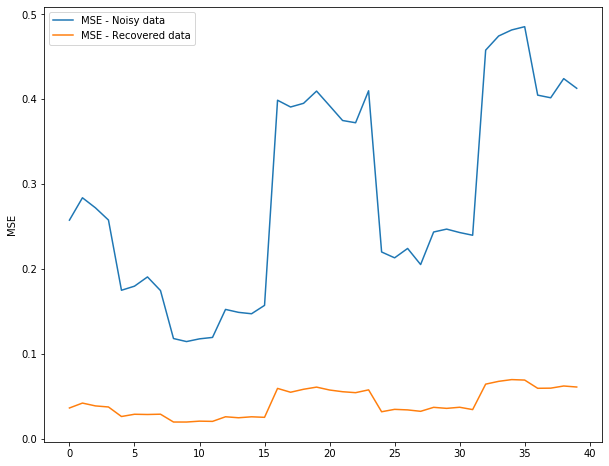

In [0]:
## Plotting the results (tentetive)
# complete this
fig = plt.figure(figsize=(10,8))
plt.plot(noisy_stat, label = 'MSE - Noisy data')
plt.plot(recovered_stat, label = 'MSE - Recovered data')
plt.ylabel('MSE')
plt.legend()

# References
[1] J. Martinez, R. Hossain, J. Romero, and J. J. Little, “A simple yet effective baseline for 3d human pose
estimation,” in ICCV, 2017.

<!--Write your report here in markdown or html-->
